<a href="https://colab.research.google.com/github/Movya777/Data-Science_Projects/blob/main/Movya_Assessment_Student_Success.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predictive Model for Student Sucess
------
Sai Sri Movya Sonti - UCONN, School of Business



# Environment Setup

In [ ]:
# import modules
# for general data analysis/plotting
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE

# for data prep
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# feature importance
from sklearn.ensemble import RandomForestRegressor

# Categorical data encoding
from sklearn.preprocessing import LabelEncoder

# Model building/evaluation/validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score

# Read Data

In [ ]:
# upload and read files from default working directory of colab
df = pd.read_csv('/content/Student Success.csv')

In [ ]:
print(df.shape) # 6607 rows, 20 columns

(6607, 20)


# EDA (Exploratory Data Analysis)

# Missing Values

Let's make sure to address any missing values before modeling, otherwise we will get an error! The loss values will be NaN if we try to build a model on dirty data with missing values.

In [ ]:
# check null values and variables datatype
info = pd.DataFrame({'Null Values': df.isnull().sum(), 'Data Type': df.dtypes})
print(info)

                            Null Values Data Type
Hours_Studied                         0     int64
Attendance                            0     int64
Parental_Involvement                  0    object
Access_to_Resources                   0    object
Extracurricular_Activities            0    object
Sleep_Hours                           0     int64
Previous_Scores                       0     int64
Motivation_Level                      0    object
Internet_Access                       0    object
Tutoring_Sessions                     0     int64
Family_Income                         0    object
Teacher_Quality                      78    object
School_Type                           0    object
Peer_Influence                        0    object
Physical_Activity                     0     int64
Learning_Disabilities                 0    object
Parental_Education_Level             90    object
Distance_from_Home                   67    object
Gender                                0    object


**Missing Value Columns**
- Teacher_Quality: 78 rows
- Parental_Education_Level: 90 rows
- Distance_from_Home: 67 rows

**Data Types**
- Numeric (int64): 7 variables
- Categorical (object): 13 variables


All of the missing data is from categorical columns. To handle missing values from categorical columns, I prefer either dropping, imputing with mode, replacing with "unknown" or predictive imputation.


Well!

Before procedding to handle missing values, lets find the contribution of each column to the target variable (If any variable seems to have very low contribution, it can be dropped)

> Though I understand that, feature importance step is not necessary right now, I wanted to get an overview of the contribution of the missing value columns

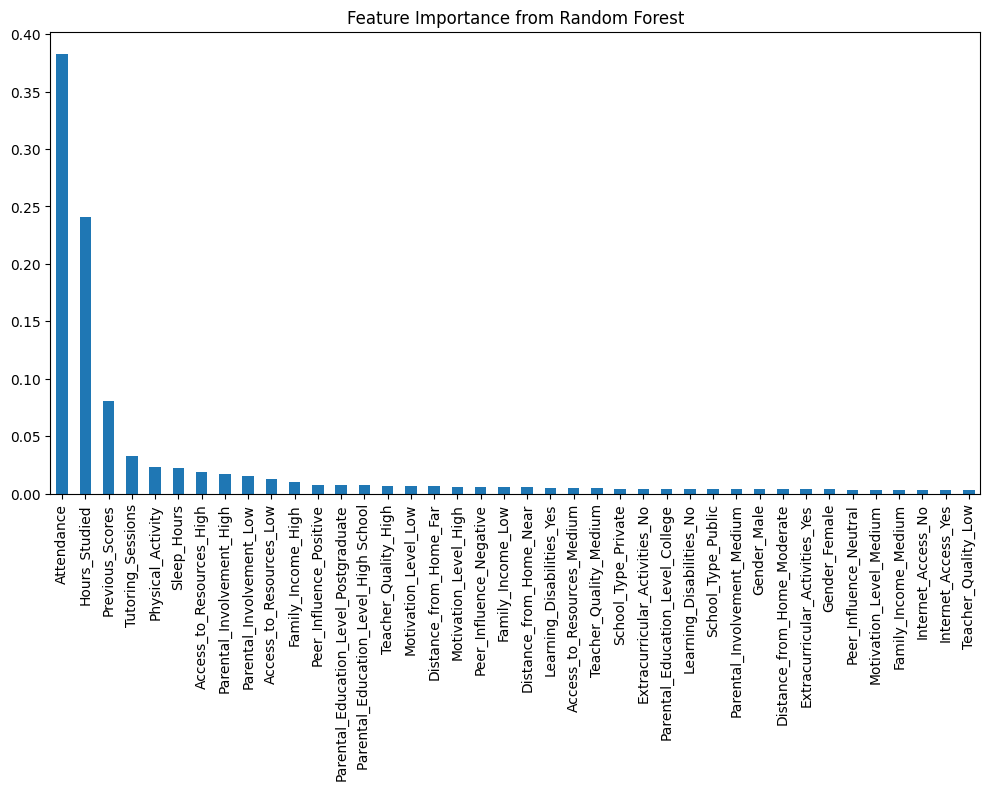

In [ ]:
# Encode categorical variables to identify the contribution of each category of a variable
df_encoded = pd.get_dummies(df, drop_first=False)

# Split into features and target variable
X = df_encoded.drop(columns=['Exam_Score']) # features
y = df_encoded['Exam_Score'] # target variable

# Train a Random Forest model
model = RandomForestRegressor()
model.fit(X, y)

# Plot feature importance
feature_importance = pd.Series(model.feature_importances_, index=X.columns)
feature_importance.sort_values(ascending=False).plot(kind='bar', figsize=(12, 6))
plt.title("Feature Importance from Random Forest")
plt.show()


From the above plot, teacher_Quality has near zero importance

HMMM....Will i drop it now??? 🤔🤔🤔

Probably NO

For the reason being...

The importance of Teacher_Quality might be low, but the impact could be due to missing values. Moreover, in real-life, Teacher_Quality plays a significant role in impacting a student's unerstanding and exam score.

For now, I will replace the missing data with "Unknown"

# Handling Missing Values

I always prefer to make a copy of the original dataframe before making any major changes to the data (for an easy access of original data in the future analysis)

In [ ]:
# make a copy
df_copy = df.copy()

In [ ]:
# replace each missing record with "Unknown"
df_copy['Parental_Education_Level'].fillna('Unknown',inplace=True)
df_copy['Distance_from_Home'].fillna('Unknown',inplace=True)
df_copy['Teacher_Quality'].fillna('Unknown',inplace=True)

<ipython-input-7-b3690646b4d9>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['Parental_Education_Level'].fillna('Unknown',inplace=True)
<ipython-input-7-b3690646b4d9>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=

Let's check whether the missing data has been replaced

In [ ]:
info_copy = pd.DataFrame({'Null Values': df_copy.isnull().sum(), 'Data Type': df_copy.dtypes})
print(info_copy)

                            Null Values Data Type
Hours_Studied                         0     int64
Attendance                            0     int64
Parental_Involvement                  0    object
Access_to_Resources                   0    object
Extracurricular_Activities            0    object
Sleep_Hours                           0     int64
Previous_Scores                       0     int64
Motivation_Level                      0    object
Internet_Access                       0    object
Tutoring_Sessions                     0     int64
Family_Income                         0    object
Teacher_Quality                       0    object
School_Type                           0    object
Peer_Influence                        0    object
Physical_Activity                     0     int64
Learning_Disabilities                 0    object
Parental_Education_Level              0    object
Distance_from_Home                    0    object
Gender                                0    object


Ta-da!!!
Our dataset is ready

.

.

.

WAIT WAIT WAIT!!!!

Before declaring, lets have a closer look

🔍🔍🔍

We have 2 types of data (numerical, categorical)

Machine learning algorithms are typically designed to operate with numerical data and they cannot directly handle categorical data.

So, categorical data needs to be encoded as numerical values.


# Categorical Data

After examining the data, I found out the following column types and decided the encoding technique based on column type

> Binary Columns: Label encoding (Yes/No --> 1/0)

> Nominal Columns: One-Hot Encoding

> Ordinal Columns: Ordinal Encoding


In [ ]:
df2=df_copy.copy() #create a copy

In [ ]:
# Label Encoding for Binary Columns
binary_columns = ['Internet_Access', 'Learning_Disabilities', 'Extracurricular_Activities']
label_encoder = LabelEncoder() # converts (Yes/No) to (1/0)

for col in binary_columns:
    df2[col] = label_encoder.fit_transform(df2[col])

In [ ]:
df2.head(2)

Hours_Studied  Attendance Parental_Involvement Access_to_Resources  \
0             23          84                  Low                High   
1             19          64                  Low              Medium   

   Extracurricular_Activities  Sleep_Hours  Previous_Scores Motivation_Level  \
0                           0            7               73              Low   
1                           0            8               59              Low   

   Internet_Access  Tutoring_Sessions Family_Income Teacher_Quality  \
0                1                  0           Low          Medium   
1                1                  2        Medium          Medium   

  School_Type Peer_Influence  Physical_Activity  Learning_Disabilities  \
0      Public       Positive                  3                      0   
1      Public       Negative                  4                      0   

  Parental_Education_Level Distance_from_Home  Gender  Exam_Score  
0              High School               Near    Male          67  
1                  College           Moderate  Female          61

In [ ]:
df3=df2.copy()

In [ ]:
# Ordinal Encoding for Ordered Categories
# Define mappings
ordinal_columns = {
    'Motivation_Level': {'Low': 1, 'Medium': 2, 'High': 3},
    'Parental_Involvement': {'Low': 1, 'Medium': 2, 'High': 3},
    'Access_to_Resources': {'Low': 1, 'Medium': 2, 'High': 3},
    'Family_Income': {'Low': 1, 'Medium': 2, 'High': 3},
    'Teacher_Quality': {'Low': 1, 'Medium': 2, 'High': 3, 'Unknown': 0}
}

# Apply ordinal encoding
for col, mapping in ordinal_columns.items():
    if col in df3.columns:
        df3[col] = df3[col].map(mapping)

In [ ]:
info_copy = pd.DataFrame({'Null Values': df3.isnull().sum(), 'Data Type': df3.dtypes})
print(info_copy)

                            Null Values Data Type
Hours_Studied                         0     int64
Attendance                            0     int64
Parental_Involvement                  0     int64
Access_to_Resources                   0     int64
Extracurricular_Activities            0     int64
Sleep_Hours                           0     int64
Previous_Scores                       0     int64
Motivation_Level                      0     int64
Internet_Access                       0     int64
Tutoring_Sessions                     0     int64
Family_Income                         0     int64
Teacher_Quality                       0     int64
School_Type                           0    object
Peer_Influence                        0    object
Physical_Activity                     0     int64
Learning_Disabilities                 0     int64
Parental_Education_Level              0    object
Distance_from_Home                    0    object
Gender                                0    object


In [ ]:
df4 = df3.copy()

In [ ]:
# One-Hot Encoding for Nominal Columns
nominal_columns = ['Gender', 'School_Type', 'Parental_Education_Level', 'Peer_Influence', 'Distance_from_Home']

# Apply one-hot encoding
df4 = pd.get_dummies(df4, columns=nominal_columns, drop_first=False)  # drop_first=False to include all the categories
df4 = df4.astype(int) # converts (True/False) into (1/0)

In [ ]:
df4.head()

Hours_Studied  Attendance  Parental_Involvement  Access_to_Resources  \
0             23          84                     1                    3   
1             19          64                     1                    2   
2             24          98                     2                    2   
3             29          89                     1                    2   
4             19          92                     2                    2   

   Extracurricular_Activities  Sleep_Hours  Previous_Scores  Motivation_Level  \
0                           0            7               73                 1   
1                           0            8               59                 1   
2                           1            7               91                 2   
3                           1            8               98                 2   
4                           1            6               65                 2   

   Internet_Access  Tutoring_Sessions  ...  \
0                1                  0  ...   
1                1                  2  ...   
2                1                  2  ...   
3                1                  1  ...   
4                1                  3  ...   

   Parental_Education_Level_High School  \
0                                     1   
1                                     0   
2                                     0   
3                                     1   
4                                     0   

   Parental_Education_Level_Postgraduate  Parental_Education_Level_Unknown  \
0                                      0                                 0   
1                                      0                                 0   
2                                      1                                 0   
3                                      0                                 0   
4                                      0                                 0   

   Peer_Influence_Negative  Peer_Influence_Neutral  Peer_Influence_Positive  \
0                        0                       0                        1   
1                        1                       0                        0   
2                        0                       1                        0   
3                        1                       0                        0   
4                        0                       1                        0   

   Distance_from_Home_Far  Distance_from_Home_Moderate  \
0                       0                            0   
1                       0                            1   
2                       0                            0   
3                       0                            1   
4                       0                            0   

   Distance_from_Home_Near  Distance_from_Home_Unknown  
0                        1                           0  
1                        0                           0  
2                        1                           0  
3                        0                           0  
4                        1                           0  

[5 rows x 30 columns]

In [ ]:
# Check the data types and null values to ensure encoding was successful
info4 = pd.DataFrame({'Null Values': df4.isnull().sum(), 'Data Type': df4.dtypes})
print(info4)

                                       Null Values Data Type
Hours_Studied                                    0     int64
Attendance                                       0     int64
Parental_Involvement                             0     int64
Access_to_Resources                              0     int64
Extracurricular_Activities                       0     int64
Sleep_Hours                                      0     int64
Previous_Scores                                  0     int64
Motivation_Level                                 0     int64
Internet_Access                                  0     int64
Tutoring_Sessions                                0     int64
Family_Income                                    0     int64
Teacher_Quality                                  0     int64
Physical_Activity                                0     int64
Learning_Disabilities                            0     int64
Exam_Score                                       0     int64
Gender_Female           

In [ ]:
df4.shape

(6607, 30)

Hooray!!! 🥳🥳🥳

All the columns are converted into numeric data type


------
Now,

Using this data lets create a predictive model that predicts if a student will **PASS** "Final Exam"

It's time to prepare the data for modelling

# Prepare data for modeling

# Work on Target variable

If a student score is greater than or equal to 70, the value is converted to 1 else 0.

1 represents PASS

0 represents FAIL

In [ ]:
pass_threshold = 70
df4['Pass'] = (df4['Exam_Score'] >= pass_threshold).astype(int)  # 1 = Pass, 0 = Fail

In [ ]:
df4 = df4.drop(columns=['Exam_Score']) # we have "Pass" column, so drop "Exam_Score" column

Now, our target variable becomes 'Pass' column

In [ ]:
# we know our target variable is 'Pass'
y = df4['Pass'] # target column
X = df4.drop('Pass', axis=1) # features column
print(X.shape, y.shape)

(6607, 29) (6607,)


In [ ]:
pass_counts = df4['Pass'].value_counts()
pass_counts

Pass
0    4982
1    1625
Name: count, dtype: int64

Wow!!
We now have 29 features with 1 target

In [ ]:
# convert to numpy array
X = np.array(X)
y = np.array(y)

In [ ]:
# split into X_train and X_test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=123)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(5285, 29) (1322, 29) (5285,) (1322,)


Now, our training dataset has 5285 rows and testing dataset with 1322 rows

To normalize the data, I use minMax scaler which scales the data to a specific range, typically between 0 and 1

It is important to note that scaling should be done only after splitting but not before.

In [ ]:
# minMax scaler
min_max_scaler = MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.transform(X_test)

Perfect !!!! 🤠🤠🤠

So far, so good. We are done with data preparation

.

.

.

*Now, straight away jump into model building by randomly choosing a model*

🏊🏊🏊

IS IT?????

NAHH...

I prefer to choose my **initial model** based on visualization of the data.
If the data looks linearly seperable, I use Logistic Regression or else non-linear models like Random Forest or Gradient Boosting.


# Data Visualization

In [ ]:
# Pairplot to check linear seperability
sns.pairplot(df4, hue='Pass')
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When 

OMG!!! Aren't the plots sooooooo MANY 😀😀😀

.

No worries

Here are the observations

> There is considerable overlapping between data points across most of the feature pairs.

> The scatter plots show non-linear patterns, with points of different classes appearing mixed.


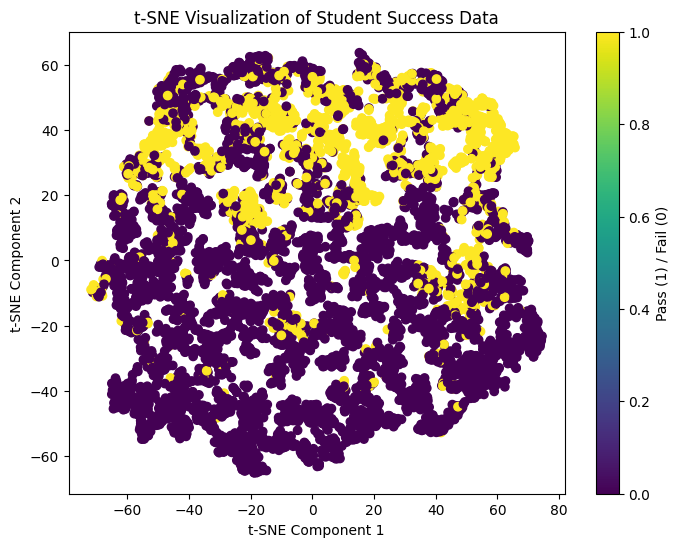

In [ ]:
# Select features for t-SNE (exclude 'Pass' column)
X = df4.drop('Pass', axis=1)
y = df4['Pass']

# # Convert categorical features to numerical using one-hot encoding
# X = pd.get_dummies(X, dummy_na=True)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization of Student Success Data')
plt.colorbar(label='Pass (1) / Fail (0)')
plt.show()

Observations from t-SNE plot:


> There is significant overlap between the two classes (Pass(yellow) and Fail(violet)).

>The lack of clear separation indicates that the classes are **not linearly separable**

Considering the observations, I choose Random Forest or Gradient boosting as my initial model and explore any other models further.

--------
> *I have initially tried Random Forest Classifier. However, Gradient Boosting showed slighlty better performance compared to Random Forest algorithm*

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid={'n_estimators':[300],
            'max_depth':[5,10,15,20,25,30],
            'min_samples_split':[2,5,10]}

In [ ]:
rf_classifier = RandomForestClassifier(random_state=42)

In [ ]:
grid_search = GridSearchCV(estimator=rf_classifier,
                           param_grid=param_grid,
                           cv=5,
                           n_jobs=-1,
                           verbose=2)

In [ ]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20, 25, 30],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 150, 200, 250, 300]},
             verbose=2)

# Predictive Model 1 - Gradient Boosting

# Training

In [ ]:
# Train a Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

# Prediction

In [ ]:
# Make predictions
y_pred_gb = gb_model.predict(X_test)
y_pred_proba_gb = gb_model.predict_proba(X_test)[:, 1]

# Performance Evalution

In [ ]:
# Evaluate the model
accuracy_gb = accuracy_score(y_test, y_pred_gb)
roc_auc_gb = roc_auc_score(y_test, y_pred_proba_gb)
print(f"Gradient Boosting Model Accuracy: {accuracy_gb:.2f}")
print(f"Gradient Boosting ROC-AUC Score: {roc_auc_gb:.2f}")

Gradient Boosting Model Accuracy: 0.93
Gradient Boosting ROC-AUC Score: 0.97


In [ ]:
# Perform cross-validation
cv_scores_gb = cross_val_score(gb_model, X_train, y_train, cv=5, scoring='accuracy')
# Print the cross-validation scores
print("Gradient Boosting Cross-Validation Scores:", cv_scores_gb)
print("Gradient Boosting Mean Cross-Validation Score:", cv_scores_gb.mean())

Gradient Boosting Cross-Validation Scores: [0.93945128 0.92715232 0.92809839 0.93093661 0.9385052 ]
Gradient Boosting Mean Cross-Validation Score: 0.9328287606433301


In [ ]:
# Print the classification report
print("Gradient Boosting Classification Report:")
print(classification_report(y_test, y_pred_gb))

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1005
           1       0.93      0.79      0.85       317

    accuracy                           0.93      1322
   macro avg       0.93      0.88      0.91      1322
weighted avg       0.93      0.93      0.93      1322



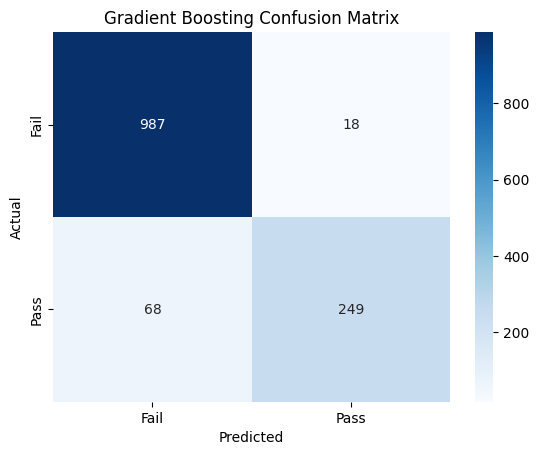

In [ ]:
# Plot the confusion matrix
conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)
sns.heatmap(conf_matrix_gb, annot=True, fmt='d', cmap='Blues', xticklabels=['Fail', 'Pass'], yticklabels=['Fail', 'Pass'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Gradient Boosting Confusion Matrix')
plt.show()

The model accuracy is quite high (0.93) indicating its effectiveness in
predicting the outcome.

A high ROC-AUC score suggests the model is capable of distinguishing between the "Pass" and "Fail" classes effectively, even with slightly imbalanced recall.

The cross-validation scores range from 0.93 to 0.94, and the mean cross-validation score is 0.92. This consistency across different folds indicates that the model generalizes well and is not overfitting.



# Feature Importance

In [ ]:
# Get feature importance
feature_importance_gb = gb_model.feature_importances_

# Create a DataFrame to display feature importance
feature_importance_df_gb = pd.DataFrame({'Feature': df4.drop('Pass', axis=1).columns, 'Importance': feature_importance_gb})

# Sort the DataFrame by importance in descending order
feature_importance_df_gb = feature_importance_df_gb.sort_values('Importance', ascending=False)

# Display the feature importance
print(feature_importance_df_gb)

                                  Feature  Importance
1                              Attendance    0.465895
0                           Hours_Studied    0.309149
3                     Access_to_Resources    0.051274
6                         Previous_Scores    0.046178
2                    Parental_Involvement    0.031207
9                       Tutoring_Sessions    0.023244
10                          Family_Income    0.012595
24                Peer_Influence_Positive    0.011281
7                        Motivation_Level    0.007914
27                Distance_from_Home_Near    0.007304
19   Parental_Education_Level_High School    0.006840
11                        Teacher_Quality    0.006595
20  Parental_Education_Level_Postgraduate    0.004474
8                         Internet_Access    0.003668
22                Peer_Influence_Negative    0.003323
12                      Physical_Activity    0.003225
4              Extracurricular_Activities    0.002510
13                  Learning

Key Observations
- Top Features: Attendance, Hours_Studied, Access_to_Resources, Previous_Scores
- Moderate Features: Parental_Involvement, Tutoring_Sessions, Family_Income,and Peer_Influence_Positive
- Least Important Features: School_Type, Gender, Peer_Influence_Neutral, Parental_Education_Level_College, Parental_Education_Level_Unknown


School_Type and Gender columns can be removed to simplify the model as they evidently showed less imporatnce.

Since, few of the records of Parental_Education_level column are missing, I do not wish to remove the column for now.

# Predictive model 2 - Logistic Regression

Logistic Regression Model Accuracy: 0.98
Logistic Regression ROC-AUC Score: 0.98
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1005
           1       0.98      0.92      0.95       317

    accuracy                           0.98      1322
   macro avg       0.98      0.96      0.97      1322
weighted avg       0.98      0.98      0.98      1322



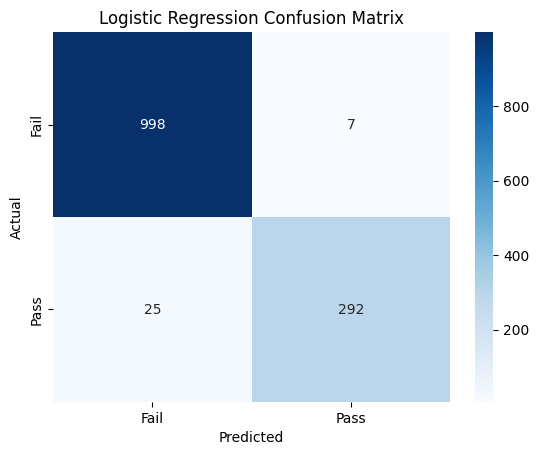

Logistic Regression Cross-Validation Scores: [0.98486282 0.97256386 0.96877956 0.97729423 0.97729423]
Logistic Regression Mean Cross-Validation Score: 0.976158940397351


In [ ]:
# Initialize the model
logreg_model = LogisticRegression(random_state=42)

# Train the model
logreg_model.fit(X_train, y_train)

# Make predictions
y_pred_logreg = logreg_model.predict(X_test)
y_pred_proba_logreg = logreg_model.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
roc_auc_logreg = roc_auc_score(y_test, y_pred_proba_logreg)

print(f"Logistic Regression Model Accuracy: {accuracy_logreg:.2f}")
print(f"Logistic Regression ROC-AUC Score: {roc_auc_logreg:.2f}")

# Print the classification report
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_logreg))

# Plot the confusion matrix
conf_matrix_logreg = confusion_matrix(y_test, y_pred_logreg)
sns.heatmap(conf_matrix_logreg, annot=True, fmt='d', cmap='Blues', xticklabels=['Fail', 'Pass'], yticklabels=['Fail', 'Pass'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

# Perform cross-validation
cv_scores_logreg = cross_val_score(logreg_model, X_train, y_train, cv=5, scoring='accuracy')

# Print the cross-validation scores
print("Logistic Regression Cross-Validation Scores:", cv_scores_logreg)
print("Logistic Regression Mean Cross-Validation Score:", cv_scores_logreg.mean())


AHHHH!!!

The result of Logistic Regression indicate its excellent performance


But, here comes the question 🤨🤨🤨

If pairplot and t-SNE plots show that the data is not linearly seperable,

HOW COME LOGISTIC REGRESSION IS PERFORMING BETTER??????



Well, the answer lies in the dimensional analysis of these plots.
- Pairplot or t-SNE visualizations typically show the separability of features in 2 or 3 dimensions
- However, Logistic Regression operates in a high-dimensional space with all available features
- In higher dimensions, linear boundaries can often be found that effectively separate the classes, even if the data looks non-linearly separable when visualized in fewer dimensions.

> Data Visualization (using plots) might serve as a starting point to choose an initial model


> For time being, I will finalize gradient boosting and logistic regression as my final models. Based on the datasize, I shall switch between in the future.


# Significant Insights

1. Feature Importance:
   - Attendance, Hours_Studied, Access_to_Resources, and Previous_Scores are the most crucial factors
     predicting student success.
   - Parental_Involvement, Tutoring_Sessions, Family_Income, and Peer_Influence_Positive also play
     a significant role.
   - Features like School_Type and Gender have less impact on student success.

2. Model Performance:
   - Both Gradient Boosting and Logistic Regression perform well in predicting student success.
   - Logistic Regression shows slightly better accuracy and AUC score, but gradient boosting
     has better cross-validation score.
   - Despite the data not being linearly separable in lower dimensions, Logistic Regression can perform
     well in higher dimensions.

3. The analysis highlights the importance of factors like student engagement, access to resources, and parental support in ensuring student success

4.  The results could be used to guide interventions and support systems for students who are at risk of failing.

5. It is imporatnt to note that the dataset had a limitation in terms of missing values.

  Solution: Making it a compulsory action to fill all the details ( columns mentioned in the dataset ) by the students could be useful in making better predictive model.

-----
🙏🙏🙏🙏🙏

I thoroughly enjoyed working with this project. Looking forward to work on larger datasets and contribute to the students' SUCCESS through my insights.

Thank you!!!